In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [1]:
datapath = '../../../data/motionstage/'

In [4]:
cfg = np.load(os.path.join(datapath, '1mm-away-rbw-800/config.npy'), allow_pickle=True).item()
nfft = cfg['nfft']
dist_start = 50
dist_end = 100
dist_vec = cfg['dist_vec'][dist_start:dist_end]

In [5]:
recData = np.load(os.path.join(datapath, '{}mm-away-rbw-800/recording.npy'.format(1)))
rp = np.fft.ifft(recData[:, 0, :], axis=1, n=nfft)[:, dist_start:dist_end]
rd = np.fft.fft(rp, axis=0)
cr_bin = np.argmax(np.sum(np.abs(rp), axis=0))
print(dist_vec[cr_bin])

0.392599301001356


Text(0.5, 1.0, '1 mm/s, CR bin phase')

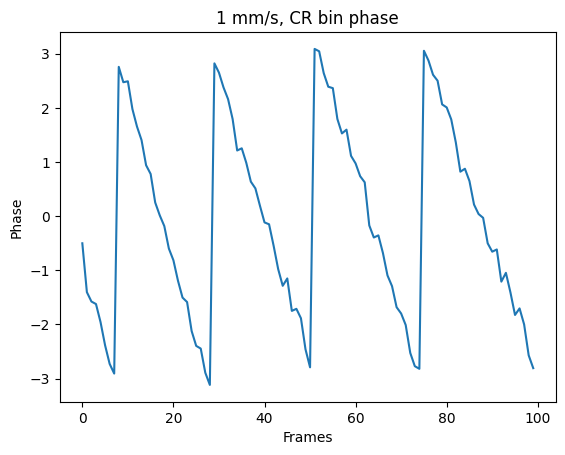

In [6]:
plt.plot(np.arange(100), np.angle(rp[:, cr_bin]))
plt.xlabel('Frames')
plt.ylabel('Phase')
plt.title('{} mm/s, CR bin phase'.format(1))

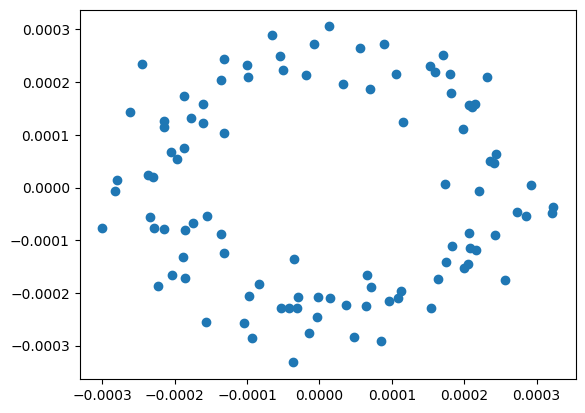

In [52]:
plt.scatter(np.real(rp[:, cr_bin]), np.imag(rp[:, cr_bin]))

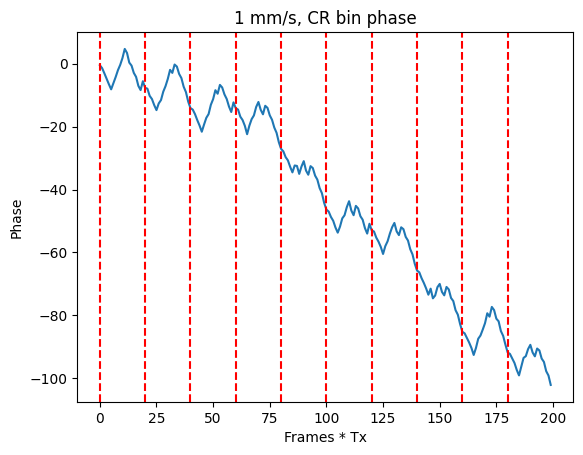

In [14]:
recData_tx = recData[:, 0::20, :].reshape(100 * 20, 150)
rp_tx = np.fft.ifft(recData_tx[:, :], axis=1, n=nfft)[:, dist_start:dist_end]
cr_bin_tx = np.argmax(np.sum(np.abs(rp_tx), axis=0))

plt.plot(np.arange(200), np.unwrap(np.angle(rp_tx[:200, cr_bin])))
# plt.plot(np.arange(200), np.angle(rp_tx[:200, cr_bin]))
plt.xlabel('Frames * Tx')
plt.ylabel('Phase')
plt.title('1 mm/s, CR bin phase')

for i in range(0, 200, 20):
    plt.axvline(x=i, color='r', linestyle='--')

Text(0.5, 1.0, '1 mm/s, CR bin IQ for different Tx')

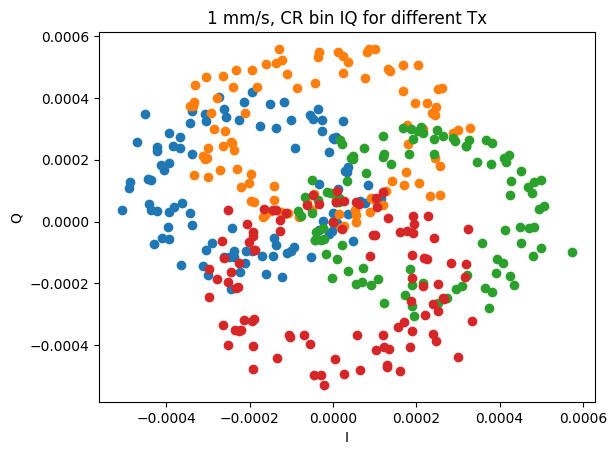

In [85]:
rp_cr = np.fft.ifft(recData[:, :, :], axis=2, n=nfft)[:, :, dist_start:dist_end][:, :, cr_bin] # frame, tx, range
rp_tx_cr = rp_cr[:, 0::20]
rp_rx_cr = rp_cr[:, :20]
for rx in range(4):
    plt.scatter(np.real(rp_tx_cr[:, rx]), np.imag(rp_tx_cr[:, rx]))
plt.xlabel("I")
plt.ylabel("Q")
plt.title("1 mm/s, CR bin IQ for different Tx")

Text(0.5, 1.0, '1 mm/s, CR bin IQ for different Rx')

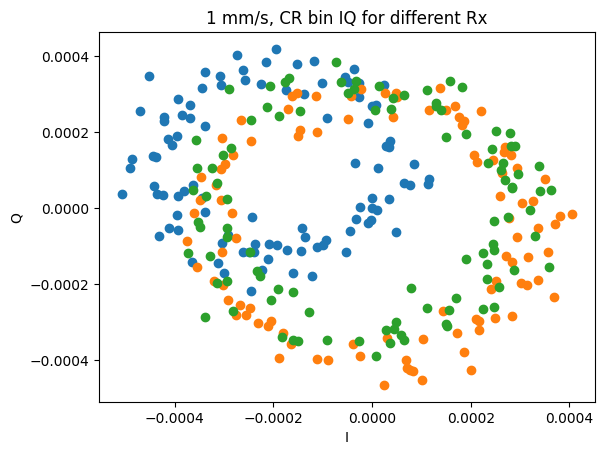

In [110]:
for rx in range(3):
    plt.scatter(np.real(rp_rx_cr[:, rx]), np.imag(rp_rx_cr[:, rx]))
plt.xlabel("I")
plt.ylabel("Q")
plt.title("1 mm/s, CR bin IQ for different Rx")

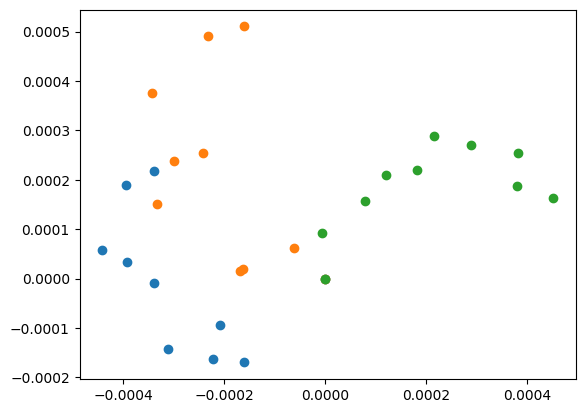

In [79]:
for tx in range(3):
    plt.scatter(np.real(rp_tx_cr[:10, tx]), np.imag(rp_tx_cr[:10, tx]))

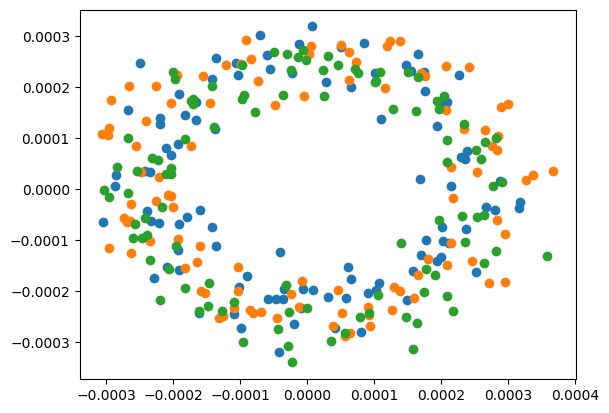

In [73]:
rp_tx_cr_cal = rp_tx_cr - np.mean(rp_tx_cr, axis=0)
for tx in range(3):
    plt.scatter(np.real(rp_tx_cr_cal[:, tx]), np.imag(rp_tx_cr_cal[:, tx]))

In [89]:
import numpy as np
from scipy.optimize import curve_fit

def fit_circle(c):
    x, y = np.real(c), np.imag(c)
    def circle_func(xy, xc, yc, r):
        return np.sqrt((xy[:, 0] - xc)**2 + (xy[:, 1] - yc)**2) - r

    # Combine x and y arrays into a single (N, 2) array
    xy = np.column_stack((x, y))

    # Fit the circle
    initial_guess = [np.mean(x), np.mean(y), np.std(x)]  # Initial guess for the circle parameters
    popt, pcov = curve_fit(circle_func, xy, np.zeros(len(xy)), p0=initial_guess)

    # Extract the fitted circle parameters
    xc_fit, yc_fit, r_fit = popt

    return xc_fit, yc_fit, r_fit


In [104]:
xc_cr, yc_cr, r_cr = np.zeros(400), np.zeros(400), np.zeros(400)
for i in range(400):
    xc_cr[i], yc_cr[i], r_cr[i] = fit_circle(rp_cr[:, i])

Text(0.5, 1.0, 'Tx radius')

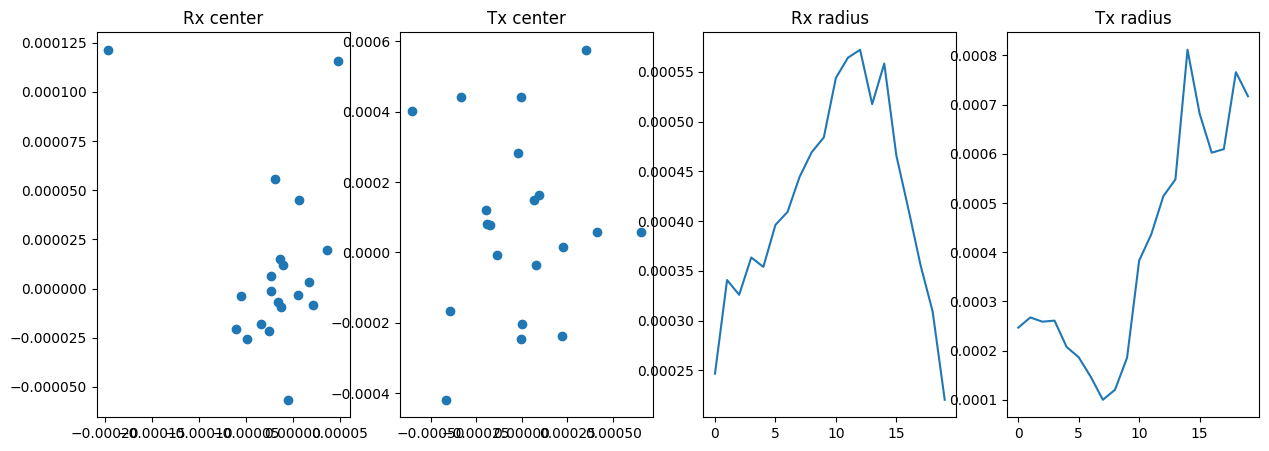

In [99]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
axes[0].scatter(xc_cr[:20], yc_cr[:20]) # Rx
axes[0].set_title('Rx center')
axes[1].scatter(xc_cr[::20], yc_cr[::20]) # Tx
axes[1].set_title('Tx center')
axes[2].plot(r_cr[:20])
axes[2].set_title('Rx radius')
axes[3].plot(r_cr[::20])
axes[3].set_title('Tx radius')

Text(0.5, 1.0, '1 mm/s, CR bin IQ for different Rx')

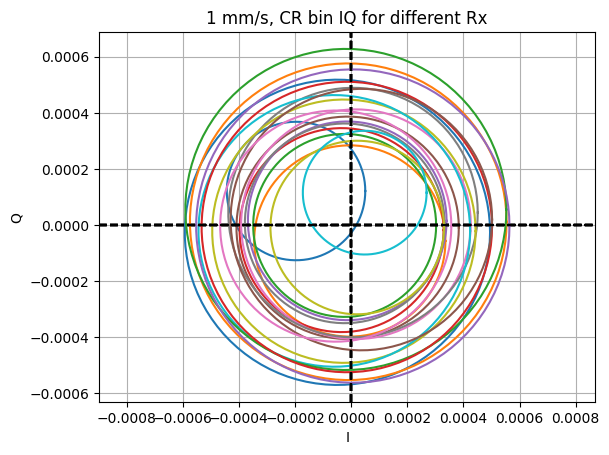

In [108]:
def plot_circle(center, radius):
    theta = np.linspace(0, 2*np.pi, 100)  # Create an array of angles
    x = center[0] + radius * np.cos(theta)  # Calculate x-coordinates of circle points
    y = center[1] + radius * np.sin(theta)  # Calculate y-coordinates of circle points

    # Plotting the circle
    plt.plot(x, y)
    plt.axhline(y=0, color='black', linestyle='--')
    plt.axvline(x=0, color='black', linestyle='--')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    plt.axis('equal')

for rx in range(20):
    plot_circle((xc_cr[rx], yc_cr[rx]), r_cr[rx])
plt.xlabel("I")
plt.ylabel("Q")
plt.title("1 mm/s, CR bin IQ for different Rx")

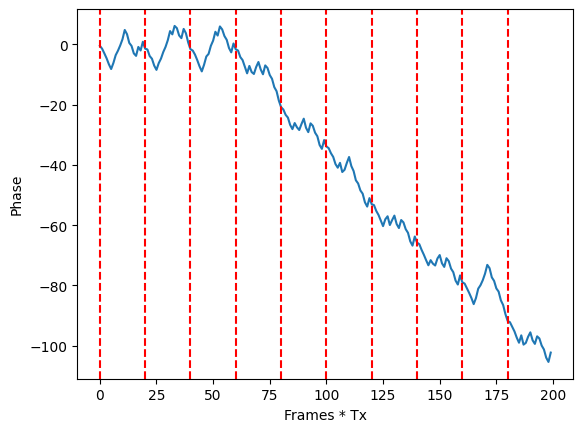

In [75]:
plt.plot(np.arange(200), np.unwrap(np.angle(rp_tx_cr_cal.reshape(-1)))[:200])
plt.xlabel('Frames * Tx')
plt.ylabel('Phase')

for i in range(0, 200, 20):
    plt.axvline(x=i, color='r', linestyle='--')

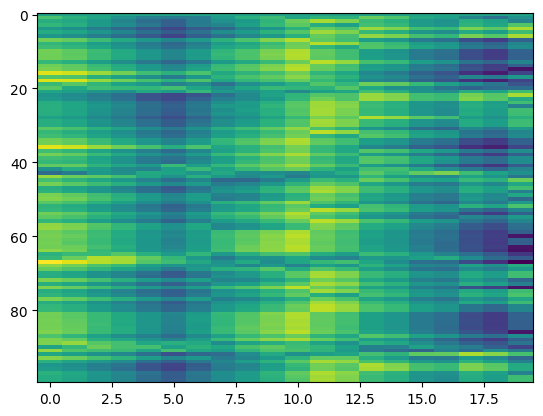

In [35]:
recData_tx_cal = recData[:, 0::20, :] # (100, 20, 150)
# recData_tx_cal = recData_tx_cal.reshape(100 * 20, 150)
rp_tx_cal = np.fft.ifft(recData_tx_cal[:, :], axis=2, n=nfft)[:, :, dist_start:dist_end]
rp_tx_cal -= rp_tx_cal[0, :, :]
angle_tx = np.angle(rp_tx_cal[:, :, cr_bin_tx]) # (100 * 20)
# angle_tx = angle_tx.reshape(100 * 20)

angle_tx = np.unwrap(angle_tx, axis=1)
angle_tx -= np.mean(angle_tx, axis=1)[:, np.newaxis]

plt.imshow(angle_tx, aspect='auto')